# Recognizer for Handwritten Text Synthesis GAN

This model will consist of 4 major networks, following the general architecture of an GAN.

1. Encoder: Produces an embedding that will be concatenated with the noise vector.
2. Generator: Taking noise vector as input and the text embedding to produce an 128x2048 image.
3. Discriminator: Trained alternating with generator input and ground-truth input, binary classification real or fake.
4. Recognizer: Taking image as input, produce a vector representation of the text.

## Import the required libraries:

In [1]:
import csv
import datetime
import os
import random
import re

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch_fidelity
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
from torch.nn.utils.spectral_norm import spectral_norm
from torch.utils.data import DataLoader, Dataset, RandomSampler, Subset, random_split
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision import datasets
from torchvision.io import read_image
from torchvision.transforms import Grayscale, Resize, ToTensor, ToPILImage
from torchvision.transforms.functional import InterpolationMode
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

from torchmetrics.text import CharErrorRate

/home/kevin/miniconda3/envs/aps360/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading

### Helper Functions (Run once only to format data)

In [2]:
SCALE_HEIGHT = 32
SCALE_WIDTH = SCALE_HEIGHT*16

def preprocess_lines(data_root):
    """
    Creates a new `.txt` file `lines_improved.txt` that will be used
    for querying. This new `.txt` file contains all info necessary
    for the functionality of this project.
    """

    original_path = os.path.join(data_root, "lines.txt")
    improved_path = os.path.join(data_root, "lines_improved.txt")
    fi = open(improved_path, "w")

    # Some variables for tracking
    num_samples = 0
    valid_samples = 0
    
    # Loop through "lines.txt"
    with open(original_path, "r") as fo:
        headers = ["image_id", "image_path", "image_pt_path", "graylevel", "original_height", "original_width", "transcription", "transcription_len"]

        # First write the headers at the top of the file
        fi.writelines("\t".join(headers) + "\n")

        # Skip the intro stuff
        for line in fo.readlines():
            if line.startswith("#"):
                continue

            # Valid lines, not the intro_text
            line_items = line.strip().split(" ")  # `strip()` to remove newlines

            # The actual items (we extract the important ones)
            image_id = line_items[0]
            status = line_items[1]
            graylevel = int(line_items[2])
            transcription = " ".join(line_items[8:])  # Some data has whitespace, we join string till the end

            # Skip error images
            if status == "err":
                continue
        
            # Alphanumeric + common punctuation regex
            # Returns None if no match
            # 26 + 26 + 10 + 9 + 1 = 72
            # Spaces might be included as well
            # Punctuation include , ! ? ' " , : ; -
            if re.fullmatch("[a-zA-Z0-9.!?'\",:;| -]*", transcription) is None:
                continue

            # Now we have valid transcription
            num_samples += 1

            # We get the `.png` image path
            inp = image_id.split("-")  # `inp` stands for image name parts
            image_path_head = os.path.join(data_root, "lines", inp[0], f"{inp[0]}-{inp[1]}")
            image_path_tail = f"{image_id}.png"
            image_path = os.path.join(image_path_head, image_path_tail)
            
            # Read image, gets its dimensions, perform processing operations, and other stuff
            tmp_image = cv.imread(os.path.join(image_path_head, image_path_tail), cv.IMREAD_GRAYSCALE)  # Removes the channel dimension
            height, width = tmp_image.shape

            # Scaling calculations
            # If width * scale >= desired length (>= to be safe)
            # Condition here to speed up overall processing time
            if width * (SCALE_HEIGHT/height) >= SCALE_WIDTH:
                continue

            resized_tensor = process_image(tmp_image, graylevel)
            image_pt_path = os.path.join(image_path_head, f"{image_id}.pt")
            torch.save(resized_tensor, image_pt_path)

            # A fully valid image
            # Separate by underscores because `transcription` has spaces so we can't split by spaces
            fi.writelines(f"{image_id}\t{image_path}\t{image_pt_path}\t{graylevel}\t{height}\t{width}\t{transcription}\t{len(transcription)}\n")
            valid_samples += 1
        
        fi.close()
    
    print("# samples:", num_samples)
    print("Valid samples:", valid_samples)


def process_image(cv_image, graylevel):
    """
    Takes in a grayscale image that OpenCV read of shape (H, W) of type uint8
    Returns a PyTorch tensor of shape (1, 32, W'), where W' is the scaled width
    This tensor is padded and effectively thresholded
    """

    # Scaling factor
    height, width = cv_image.shape
    scale = SCALE_HEIGHT/height
    scaled_width = int(width*scale)

    # Trick here is to apply threshold before resize and padding
    # This allows OpenCV resizing to create a cleaner output image
    # 2nd return value is the thresholded image
    output = cv.threshold(cv_image, graylevel, 255, cv.THRESH_BINARY)[1]

    # INTER_AREA recommended for sizing down
    output = cv.resize(output, (scaled_width, SCALE_HEIGHT), interpolation=cv.INTER_AREA)

    # Turn it back to a tensor and map to [0, 1]
    output = torch.from_numpy(output).unsqueeze(0).type(torch.float32)
    output = (output-output.min()) / (output.max()-output.min())
    
    # Add padding
    _, _, resized_height = output.shape
    padding_to_add = SCALE_WIDTH - resized_height
    output = F.pad(output, (0, padding_to_add), value=1.0)

    return output

# Uncomment this if your data isn't processed yet
# preprocess_lines("./data/")

### Important Dict (Run everytime before training)

In [3]:
# Sorted by ascii code
valid = [
    ' ', '!', '"', "'", ',', '-', '.',
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
    ':', ';', '?', 
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'
]
# Enumerate from 1 to save space for padding
# Reserve 0 for CTC blank
char_to_int = {v: i for i, v in enumerate(valid, 1)}
int_to_char = {i: v for i, v in enumerate(valid, 1)}

In [4]:
class LineDataset(Dataset):
    def __init__(self, lines_improved_dir, ty=None):
        """
        params:
            lines_improved_dir: path to the `lines_improved.txt` file
            ty: type of the dataset "txt", "img" for text dataset or image dataset.
        """
        
        # Dataframe containing the stuff in `lines_improved.txt`
        self.lines_df = pd.read_csv(lines_improved_dir, sep="\t", quoting=csv.QUOTE_NONE)

        # Class properties
        self.ty = ty  # Type of dataset (lines, images, or both)
        self.max_transcription_len = max(self.lines_df["transcription_len"])

        # Temp variables...
        length = self.lines_df.shape[0]
        line_datas = self.lines_df.iloc
        ret_texts = [line_datas[i]["transcription"].replace('|', ' ') for i in range(length)]
        ret_ctois = [torch.tensor([char_to_int[char] for char in ret_texts[i]]) for i in range(length)]

        # ...for the important data
        if self.ty in ("txt", None):  # Added this condition to speed thigns up if only text
            self.ret_ctoi_paddeds = [F.pad(ret_ctois[i], pad=(0, self.max_transcription_len-len(ret_ctois[i])), value=0) for i in range(length)]
        if self.ty in ("img", None):
            self.ret_images = [torch.load(line_datas[i]["image_pt_path"]) for i in range(length)]

    def __len__(self):
        return len(self.lines_df)
    
    def __getitem__(self, index):
        # Different type of individual loaders
        if self.ty == "txt":
            return self.ret_ctoi_paddeds[index]
        elif self.ty == "img":
            return self.ret_images[index]
        else:
            return self.ret_images[index], self.ret_ctoi_paddeds[index]

In [5]:
line_transcription_dataset = LineDataset("./data/lines_improved.txt", ty="txt")
line_image_dataset = LineDataset("./data/lines_improved.txt", ty="img")
line_dataset = LineDataset("./data/lines_improved.txt")

# Don't change this, we want to maintain consistent split
torch.manual_seed(12345678)  # DO NOT REMOVE THIS LINE
line_transcription_dataset_train, line_transcription_dataset_val = random_split(line_transcription_dataset, [0.8, 0.2])
line_image_dataset_train, line_image_dataset_val = random_split(line_image_dataset, [0.8, 0.2])
line_dataset_train, line_dataset_val = random_split(line_dataset, [0.8, 0.2])

# To train on a small dataset
line_transcription_dataset_train = Subset(line_transcription_dataset_train, range(64*5))
line_transcription_dataset_val = Subset(line_transcription_dataset_val, range(10))

line_image_dataset_train = Subset(line_image_dataset_train, range(64*5))
line_image_dataset_val = Subset(line_image_dataset_val, range(10))

line_dataset_train = Subset(line_dataset_train, range(5000))
line_dataset_val = Subset(line_dataset_val, range(100))

# line_transcription_dataset_train, line_transcription_dataset_val, _ = random_split(line_transcription_dataset, [0.005, 0.005, 0.99])
# line_image_dataset_train, line_image_dataset_val, _ = random_split(line_image_dataset, [0.005, 0.005, 0.99])
# line_dataset_train, line_dataset_val = random_split(line_dataset, [0.0025, 0.9975])

print("lines")
print(len(line_transcription_dataset_train), len(line_transcription_dataset_val))
print("images")
print(len(line_image_dataset_train), len(line_image_dataset_val))
print("both")
print(len(line_dataset_train), len(line_dataset_val))


KeyboardInterrupt: 

In [6]:
image, label = line_dataset_train[0]
print(image.shape)
plt.title("".join([int_to_char[int(val)] for val in label[label.nonzero()]]))
print(image.squeeze(0).shape)
plt.imshow(image.squeeze(0), cmap='gray')
label, "".join([int_to_char[int(val)] for val in label[label.nonzero()]])
# line_dataset.lines_df.iloc[798]

NameError: name 'line_dataset_train' is not defined

Define Key Functions

In [7]:
torch.manual_seed(0)
class Recognizer(nn.Module):
    """
    RNN:
    Input with a N x 1 x 32 x 512 image
    Output a vector representation of the text size N x 73 x (82*2+1)
    Purpose is to recognize the text from the image, to encourage the generator to produce images that are representations of the text
    """
    
    def __init__(self):
        super().__init__()
        self.name = "recognizer"
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(num_features=8)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3)
        self.bn2 = nn.BatchNorm2d(num_features=16)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(4,2))
        self.bn4 = nn.BatchNorm2d(num_features=64)
        #self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(4,2))
        #self.bn5 = nn.BatchNorm2d(num_features=128)
        #self.conv6 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(4,2))
        #self.bn6 = nn.BatchNorm2d(num_features=256)
        self.lstm = nn.LSTM(input_size=64, hidden_size=64, num_layers=3, bidirectional=True, batch_first=True)
        self.dense = nn.Linear(128, 73)
        self.dense2 = nn.Linear(250, 82)

        self.lrelu = nn.LeakyReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout2d(p=0.3)
        
    def forward(self, img):
        img = self.bn1(self.lrelu(self.maxpool(self.conv1(img))))
        #print(img.shape)
        img = self.bn2(self.lrelu(self.conv2(img)))
        #print(img.shape)
        img = self.bn3(self.lrelu(self.dropout(self.conv3(img))))
        #print(img.shape)
        img = self.bn4(self.lrelu(self.dropout(self.conv4(img))))
        #print(img.shape)
        #img = self.bn5(self.lrelu(self.dropout(self.conv5(img))))
        #print(img.shape)
        # Collapse 
        img, _ = torch.max(img, dim=2)
        #print(img.shape)
        img = img.permute(0, 2, 1)
        #print(img.shape)
        img, _ = self.lstm(img)
        #print(img.shape)
        img = self.lrelu(self.dense(img))
        #print(img.shape)
        img = img.permute(0,2,1)
        img = self.dense2(img)
        #print(img.shape)
        #print(img.shape)
        return img
        # img = torch.stack()
        # img = self.dense(img)
    
recog = Recognizer()
a =recog(torch.randn((1, 1, 32, 512), dtype=torch.float32))
#print(recog)
    # TODO: http://www.tbluche.com/files/icdar17_gnn.pdf use "big architecture"
a.shape

torch.Size([1, 73, 82])

In [9]:
def evaluate(device, recognizer, val_line_dataset_loader, recognizer_loss_function):
    recognizer.eval() 
    total_loss = 0.0
    total_epoch = 0
    
    for i, (line_image_batch, line_text_batch) in enumerate(val_line_dataset_loader, 0):
        line_image_batch = line_image_batch.to(device) 
        line_text_batch = line_text_batch.to(device)
        recognizer_outputs = recognizer(line_image_batch)
        recognizer_loss = recognizer_loss_function(F.log_softmax(recognizer_outputs, 1), line_text_batch)
        
        total_loss += recognizer_loss.item()
        total_epoch += 1
        
    loss = float(total_loss) / (i + 1)
    
    #print(recognizer_outputs, recognizer_outputs.shape)
    #print(torch.argmax(recognizer_outputs, 1), torch.argmax(recognizer_outputs, 1).shape)
    return loss


def calculate_recog_accuracy(preds, target):
    """
    Calculates the accuracy of the recognizer with character error rate
    which is based on edit distance

    Params:
        preds: a list of prediction strings
        targets: a list of target strings

    Returns:
        An integer, the character error rate average across
        all predictions and targets
    """

    cer = CharErrorRate()
    return cer(preds, target)

def create_strings_from_tensor(int_tensor):
    """
    Params:
        int_tensor: A shape (N, 82) tensor where each row corresponds to
        a integer mapping of a string. Includes padding
    
    Returns:
        A list of N strings
    """

    strings = []
    for string_map in int_tensor:
        strings.append("".join([int_to_char[int(i)] for i in string_map[string_map != 0]]))
    return strings
    

def get_accuracy(device, recognizer, recognizer_loader):

    acc = 0
    
    for i, (line_image_batch, line_text_batch) in enumerate(recognizer_loader, 0):
        line_image_batch = line_image_batch.to(device)
        line_text_batch
        recognizer_outputs = torch.argmax(recognizer(line_image_batch), 1)
        recognizer_pred = create_strings_from_tensor(recognizer_outputs)
        
        label = create_strings_from_tensor(line_text_batch)
        
        acc += calculate_recog_accuracy(recognizer_pred, label)
        
        
    return acc / (i+1)
        
    

def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def plot_training_curve(path):
    import matplotlib.pyplot as plt
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    
    train_acc = np.loadtxt("{}_train_acc.csv".format(path))
    val_acc = np.loadtxt("{}_val_acc.csv".format(path))
    
    n = len(train_loss) # number of epochs
    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Train Loss", "Validation Loss"])
    plt.show()
    
    plt.title("Train vs Validation Error")
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Error")
    plt.legend(["Train Error", "Validation Error"])
    plt.show()

In [10]:
def train(recognizer, 
              train_line_dataset, val_line_dataset, 
              batch_size=64, recognizer_lr=1e-5,
              betas=(0, 0.999), num_epochs=30, loss_balancing_alpha=1):
    # Note, the generator and discriminator should be spectrally normalized before training
    # TODO: load dataloader with batch size batch_size

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # device = torch.device('cpu')
    #print(device)
    recognizer = recognizer.to(device)
    
    train_line_dataset_loader = DataLoader(train_line_dataset, batch_size=batch_size, shuffle=True)
    val_line_dataset_loader = DataLoader(val_line_dataset, batch_size=batch_size, shuffle=True)
    
    #print(len(train_line_dataset_loader))

    recognizer_optimizer = optim.Adam(recognizer.parameters(), lr=recognizer_lr)
    
    recognizer_loss_function = nn.NLLLoss()
    
    torch.nn.utils.clip_grad_norm_(recognizer.parameters(), max_norm=0.5)
    recognizer_train_losses = np.zeros(num_epochs)
    recognizer_train_accuracies = np.zeros(num_epochs)
    recognizer_val_losses = np.zeros(num_epochs)
    recognizer_val_accuracies = np.zeros(num_epochs)

    for epoch in range(num_epochs):
        display_images = []

        recognizer_train_loss = 0

        for i, (line_image_batch, line_text_batch) in enumerate(train_line_dataset_loader):
#             print("epoch", epoch, "batch", i)
#             print("line_image_batch.shape", line_image_batch.shape)
            cur_batch_size, _ = line_text_batch.shape
            # print(line_text_batch.shape)

#             print("line_text_batch.shape", line_text_batch.shape)
            test = line_text_batch[0]
            test = test[test.nonzero()]
            test = "".join([int_to_char[int(i)] for i in test])
            line_image_batch = line_image_batch.to(device)
            line_text_batch = line_text_batch.to(device)
            plt.imshow(line_image_batch[0].cpu().squeeze(0), cmap='gray')
            #print(line_text_batch, line_text_batch.shape)
            recognizer_outputs = recognizer(line_image_batch)  # Mult factor to incentivize padding
   
            # print(recognizer_outputs, recognizer_outputs.shape)
            # print(line_text_batch, line_text_batch.shape)
#             test2 = "".join([int_to_char[int(i)] for i in test2])

#             Refer to CTC documentation
            #line_text_batch_pad_remove = [line_text[line_text.nonzero().squeeze(1)] for line_text in line_text_batch]  # Array of tensors
            #target_lengths = torch.tensor([len(line_text_pad_remove) for line_text_pad_remove in line_text_batch_pad_remove])
            #target = torch.cat(line_text_batch_pad_remove)
            #print(target, target.shape)
            #input_lengths = torch.full(size=(cur_batch_size,), fill_value=248)
            recognizer_loss = recognizer_loss_function(
                # torch.argmax(F.log_softmax(recognizer_outputs, 2), 1),
                F.log_softmax(recognizer_outputs, 1),  # Requires number of classes to move from 2nd to 1st dimension after log_softmax
                line_text_batch
            )
            test2 = recognizer_outputs[0,:,:]
            test2 = torch.argmax(test2, dim=0)  # Removed 0 dim
            test2 = test2[test2.nonzero()]
            test2 = "".join([int_to_char[int(i)] for i in test2])
            

            recognizer_loss.backward()
            recognizer_optimizer.step()
            recognizer_optimizer.zero_grad()
    
            recognizer_train_loss += recognizer_loss.item()
        
        print("\t",test)
        print(f"_{test2}_")
        recognizer_train_losses[epoch] = float(recognizer_train_loss) / (i+1)
        
        recognizer.eval()
        recognizer_val_losses[epoch] = evaluate(device, recognizer, val_line_dataset_loader, recognizer_loss_function)
        recognizer.train()
        
        recognizer_train_accuracies[epoch] = get_accuracy(device, recognizer, train_line_dataset_loader)
        recognizer_val_accuracies[epoch]= get_accuracy(device, recognizer, val_line_dataset_loader)
        
        print(("Epoch {}: Train loss: {} | Train Accuracy: {} | "+
            " Validation loss: {} | Validation Accuracy: {}").format(
                    epoch + 1,
                    recognizer_train_losses[epoch],
                    recognizer_train_accuracies[epoch],
                    recognizer_val_losses[epoch],
                    recognizer_val_accuracies[epoch]))

        model_path = get_model_name(recognizer.name, batch_size, recognizer_lr, epoch)
        torch.save(recognizer.state_dict(), os.path.join("./recognizers", model_path))
        model_path_const_batch = get_model_name(recognizer.name, batch_size, recognizer_lr, -1)

        np.savetxt("./recognizers/{}_train_loss.csv".format(model_path_const_batch), recognizer_train_losses)
        np.savetxt("./recognizers/{}_val_loss.csv".format(model_path_const_batch),  recognizer_val_losses)
        np.savetxt("./recognizers/{}_train_acc.csv".format(model_path_const_batch), recognizer_train_accuracies)
        np.savetxt("./recognizers/{}_val_acc.csv".format(model_path_const_batch), recognizer_val_accuracies)

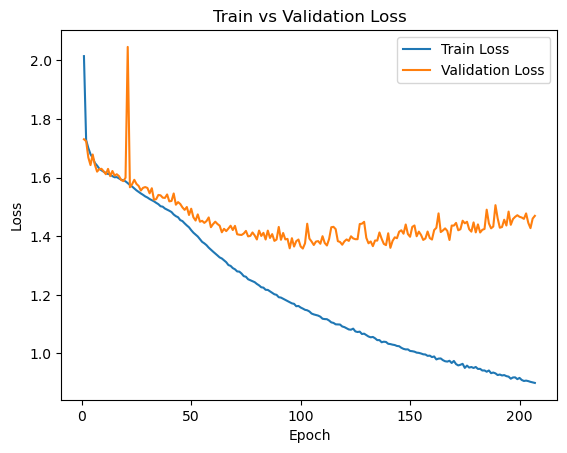

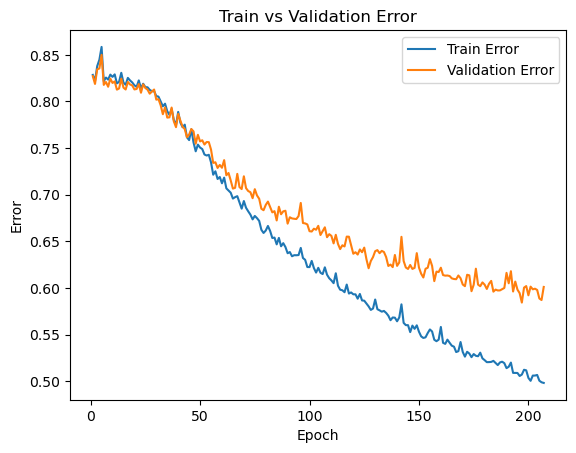

In [10]:
plot_training_curve("./recognizers/model_recognizer_bs8_lr0.0005_epoch-1")

## Define Network Classes

### Define Main Networks

## Significant Hyperparameters to Tune
- Dimension of text embedding, we can start with 128, 256, or 512 and increase it later on.
- Dataset of training. If the model does not converge, it is likely we will have to manually select example images that have similar writing style.
- Learning rate
- Balancing the effect of recognizer and discriminator

- Generator Networks:
  - ResNetUp
    - Should the bias be False? Or can it be True?
      - conv1 probably don't, since it is batch-normalized right after
      - but what about conv2?
  - Conditional Batch Norm
  - Number of filters in each resnet block

LSTM hidden layers should increase, hidden size should increase. 
- because our text is longer. 

- Discriminator Networks:
  - ResNetDown
    - Still if bias should be False?
    - LeakyReLU slope
  - ResNet
    - bias?
    - leakyReLU slope



In [11]:
recognizer = Recognizer()
# generator = load_model(generator, "main_model/model_snapshots/2023-07-13_18-06-43_bs4_lr0.0002_betas(0, 0.999)_generator_epoch9.pt")
# generator, encoder, discriminator = load_models_of_same_batch(generator, encoder, discriminator, filename_prefix="main_model/model_snapshots/2023-07-13_18-06-43_bs4_lr0.0002_betas(0, 0.999)", epoch_number=9)

train(recognizer=recognizer, 
              train_line_dataset=line_dataset_train, val_line_dataset=line_dataset_val, 
              batch_size=8, recognizer_lr=5e-4,
              betas=(0, 0.999), num_epochs=500, loss_balancing_alpha=1)

	 Prime Minister of the outcome of his recent
_e    e                                 _
Epoch 1: Train loss: 2.0141054933547973 | Train Accuracy: 0.8284528255462646 |  Validation loss: 1.7306637672277598 | Validation Accuracy: 0.8270955681800842
	 Shepard and that Salvation Army chap Gagarin -
_oe                                   _
Epoch 2: Train loss: 1.7276952793121338 | Train Accuracy: 0.8219119310379028 |  Validation loss: 1.7240378764959483 | Validation Accuracy: 0.818757951259613
	 To complete the job , screw two fittings to the
_oe                                       _
Epoch 3: Train loss: 1.700742059135437 | Train Accuracy: 0.8378636837005615 |  Validation loss: 1.6684032403505766 | Validation Accuracy: 0.8344088196754456
	 simple and coherent plan . To understand how
_ot                                              _
Epoch 4: Train loss: 1.6795901292800903 | Train Accuracy: 0.8447688221931458 |  Validation loss: 1.6423922777175903 | Validation Accuracy: 0.8353510499000549
	

KeyboardInterrupt: 

torch.Size([1, 32, 512])
torch.Size([32, 512])
tensor([[0.0137, 0.0137, 0.0137,  ..., 0.0137, 0.0139, 0.0137],
        [0.0138, 0.0138, 0.0138,  ..., 0.0138, 0.0134, 0.0138],
        [0.0137, 0.0138, 0.0137,  ..., 0.0137, 0.0135, 0.0137],
        ...,
        [0.0140, 0.0140, 0.0140,  ..., 0.0139, 0.0135, 0.0139],
        [0.0137, 0.0137, 0.0137,  ..., 0.0138, 0.0139, 0.0137],
        [0.0137, 0.0137, 0.0137,  ..., 0.0137, 0.0138, 0.0137]],
       grad_fn=<SoftmaxBackward0>) torch.Size([82, 73])


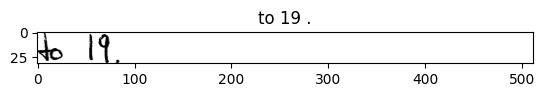

In [108]:
image, label = line_dataset_train[0]
print(image.shape)
plt.title("".join([int_to_char[int(val)] for val in label[label.nonzero()]]))
print(image.squeeze(0).shape)
plt.imshow(image.squeeze(0), cmap='gray')
label, "".join([int_to_char[int(val)] for val in label[label.nonzero()]])

print(torch.softmax(recognizer(image.unsqueeze(0)), 1), torch.softmax(recognizer(image.unsqueeze(0)), 1).shape)